# 4_metrics_nucleus_celltype_diversity

This notebook demonstrates the calculation and visualization of metrics for the level of transcriptomic diversity across the thalamus, evaluated as a function of the local distribution of taxonomic cell types.

In [1]:
import seaborn as sns

from abc_merfish_analysis import ccf_plots as cplot
from abc_merfish_analysis import abc_load as abc
from abc_merfish_analysis import ccf_erode as cerd
from abc_merfish_analysis import diversity_metrics as divmet
from abc_merfish_analysis import diversity_plots as dplot

get_ipython().run_line_magic('matplotlib', 'inline') 
cplot.CCF_REGIONS_DEFAULT = abc.get_thalamus_names()

## Load ABC Thalamus dataset

In [2]:
# load just the obs
obs = abc.load_standard_thalamus(data_structure='obs')

In [3]:
# load CCF image volumes
realigned=False
ccf_images = abc.get_ccf_labels_image(resampled=True, realigned=realigned)

In [4]:
# set spatial column names to `_reconstructed` coordinate space
coords = '_reconstructed'
x_col = 'x'+coords
y_col = 'y'+coords
section_col = z_col = 'z'+coords

## Define eroded CCF regions

Diversity metrics for regions are very sensitive to the precise location of region borders - diversity will be strongly inflated if the annotated region contains cells that actually belong to neighboring regions. Since visual inspection of alignment results has shown them to be imperfect in some parts of the thalamus, we mitigate this effect by calculating cell-type distributions only for the "core" of each region (cells that are at least 50 um from the region borders).

In [5]:
ccf_metrics_level = "structure"
obs_erode, ccf_label_eroded = cerd.label_cells_by_eroded_ccf(obs, ccf_images, ccf_level=ccf_metrics_level, distance_px=5) # default is erosion by 5px (50um)

We also drop one section (6.6) from the calculations entirely -- due to issues with the anterior-posterior positioning at the coarse alignment stage, the parafascicular nucleus (PF) is only annotated in a tiny proportion of the section, while PF cell types clearly cover a significant portion.

In [6]:
# So, we'll set all cells in section 6.6 to 'unassigned' CCF structure
obs_erode.loc[lambda df: df['z_section']==6.6, ccf_label_eroded] = 'unassigned'

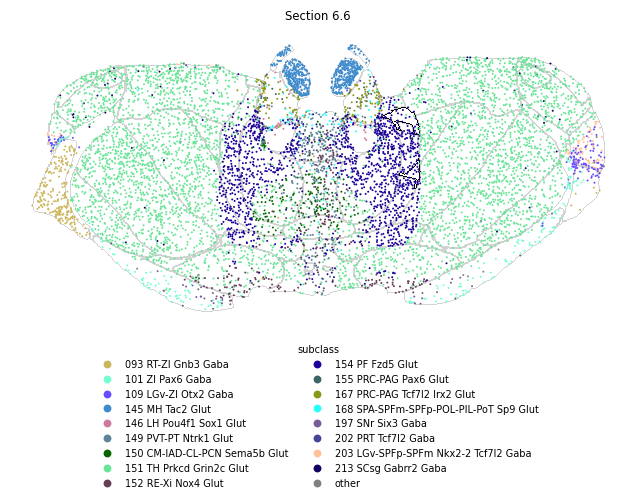

In [7]:
# We can visualize this mismatch (see `154 PF Fzd5 Glut` subclass in dark blue) 
# by using our plotting functions from the `2_view_thalamus_celltypes_ccf` notebook
taxonomy_level = ['subclass']#, 'supertype']
for level in taxonomy_level:
    sec66_fig = cplot.plot_ccf_overlay(obs_erode, ccf_images, 
                                        point_hue=level, 
                                        sections=[6.6],
                                        ccf_highlight=['PF'],
                                        point_palette=abc.get_taxonomy_palette(level),
                                        legend='cells',
                                        section_col=section_col,
                                        x_col=x_col, 
                                        y_col=y_col,)

## Calculate default set of metrics

We calculate the following metrics: count of distinct types (raw, normalized by cell count, and fraction of all types), count of distinct types containing at least 5 cells in the region (raw and fractional), inverse Simpson's index, and Shannon index. Each metric is evaluated for types at the cluster, supertype, and subclass level of the taxonomy.

In [8]:
ccf_label='parcellation_structure_eroded'
th_ccf_metrics = divmet.calculate_diversity_metrics(obs_erode, ccf_label=ccf_label)
th_ccf_metrics.columns

Index(['count_cluster', 'count_supertype', 'count_subclass', 'frac_cluster',
       'frac_supertype', 'frac_subclass', 'count_norm2cells_cluster',
       'count_norm2cells_supertype', 'count_norm2cells_subclass',
       'count_gt5_cluster', 'count_gt5_supertype', 'count_gt5_subclass',
       'frac_gt5_cluster', 'frac_gt5_supertype', 'frac_gt5_subclass',
       'inverse_simpsons_cluster', 'inverse_simpsons_supertype',
       'inverse_simpsons_subclass', 'shannon_index_cluster',
       'shannon_index_supertype', 'shannon_index_subclass', 'count_cells'],
      dtype='object')

## Plot default metrics

### Select regions to plot

For ease of plotting, we select a subset of regions focusing on relevant comparisons to the literature and excluding very small or low cell count regions.

In [9]:
regions_to_plot = abc.TH_DIVERSITY_STRUCTURES

### Plot cluster count & fraction on dual y-axis barplot

Since cluster fractional count is simply a rescaling of cluster count, we can display both with dual y axes on a single plot.

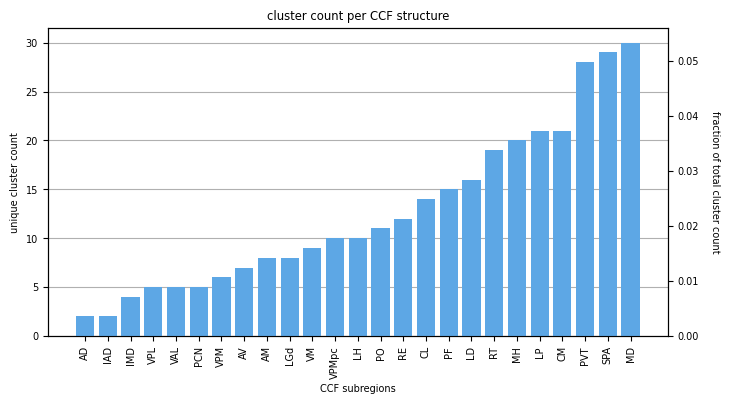

In [10]:
fig = dplot.barplot_dual_y_count_frac(th_ccf_metrics.loc[regions_to_plot], 'cluster', 
                                gt5_only=True)
# fig.savefig("/results/nuclei_cluster_counts_barplot.pdf", transparent=True)

### Plot diversity at multiple taxonomy levels (cell type count)

Diversity at different levels of the taxonomy is highly correlated but not always directly proportional. We plot all levels together, sorted by the cluster-level diversity, in order to visualize this.

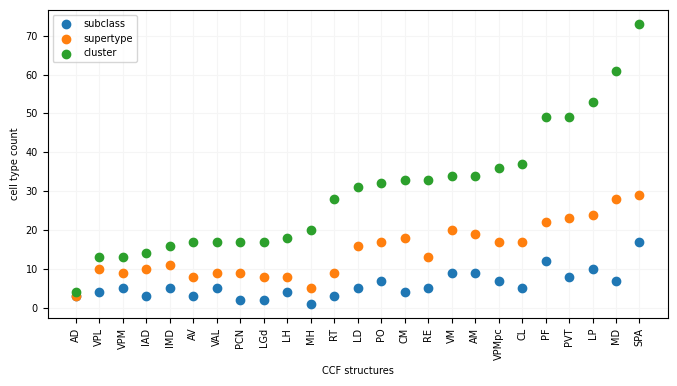

In [11]:
fig = dplot.plot_metric_multiple_levels(th_ccf_metrics.loc[regions_to_plot], 
                                          'count',
                                          ylabel="cell type count")

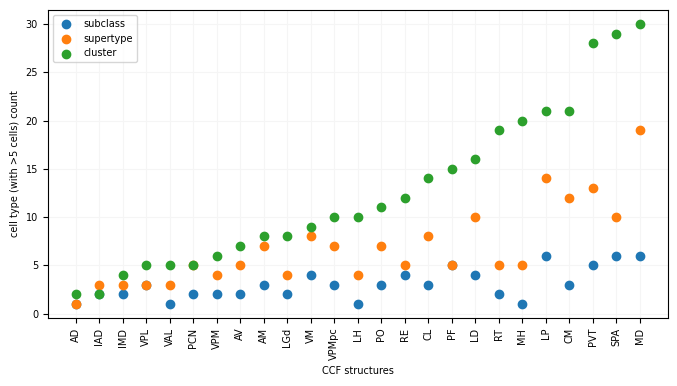

In [12]:
fig = dplot.plot_metric_multiple_levels(th_ccf_metrics.loc[regions_to_plot], 
                                          'count_gt5',
                                          ylabel='cell type (with >5 cells) count')

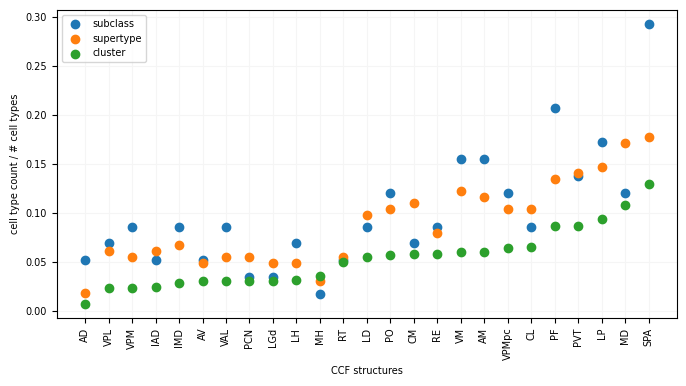

In [13]:
fig = dplot.plot_metric_multiple_levels(th_ccf_metrics.loc[regions_to_plot], 
                                          'frac',
                                          ylabel='cell type count / # cell types')

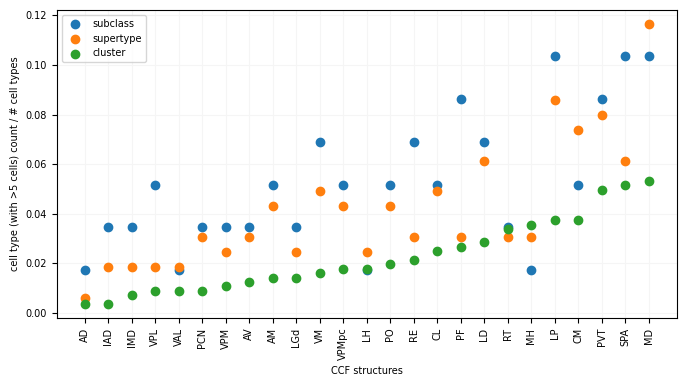

In [14]:
fig = dplot.plot_metric_multiple_levels(th_ccf_metrics.loc[regions_to_plot], 
                                          'frac_gt5',
                                          ylabel='cell type (with >5 cells) count / # cell types')

### Accounting for relationships to CCF region size


There is a wide range of sizes (here, we mean # of cells) & cell densities across thalamic CCF structures:

In [ ]:
print('thalamic structure with fewest cells:\n', 
      th_ccf_metrics.loc[regions_to_plot]['count_cells'].idxmin(), 
      th_ccf_metrics.loc[regions_to_plot]['count_cells'].min())
print('thalamic structure with most cells:\n', 
      th_ccf_metrics.loc[regions_to_plot]['count_cells'].idxmax(), 
      th_ccf_metrics.loc[regions_to_plot]['count_cells'].max())


thalamic structure with fewest cells:
 IAD 128
thalamic structure with most cells:
 VPM 3801


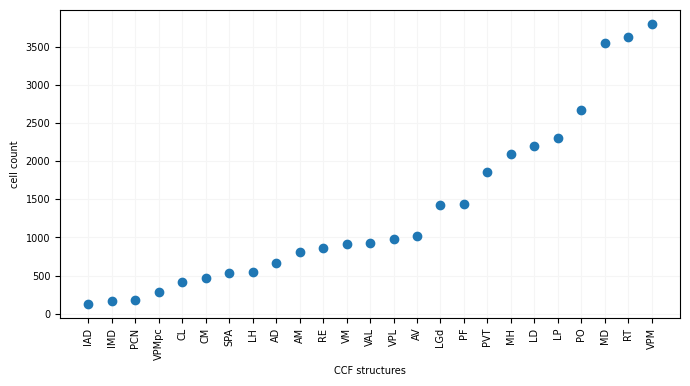

In [16]:
fig = dplot.plot_metric_multiple_levels(th_ccf_metrics.loc[regions_to_plot], 
                                        'count_cells', 
                                        taxonomy_levels=None,
                                        ylabel='cell count')

The effect of cell count on cluster count is weak, but present. We can plot normalized cluster count for a different view of diversity accounting for this contribution.

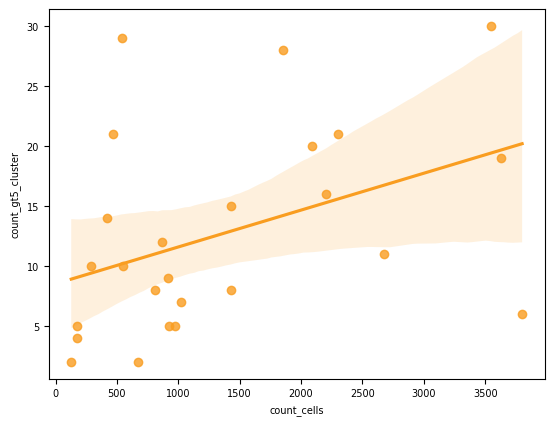

In [17]:
# effect of region size is weak but probably still present...
sns.regplot(th_ccf_metrics.loc[regions_to_plot], x='count_cells', y='count_gt5_cluster', 
            color='#F99D20', label='cluster');

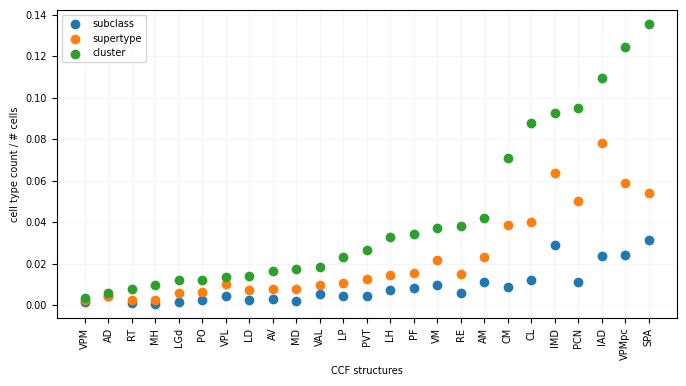

In [18]:
fig = dplot.plot_metric_multiple_levels(th_ccf_metrics.loc[regions_to_plot], 
                                          'count_norm2cells', 
                                          ylabel='cell type count / # cells')

## Spatial view of region-wise diversity

We have also provided a function in `ccf_plots` that allows you to shade the 
CCF structures by a given metric.

We display 'cluster count / # cells' as a usage example.

In [19]:
# need to load the CCF image volumes
ccf_images = abc.get_ccf_labels_image(resampled=True).astype(int)

# pick the same 3 example sections used in the `2_view_thalamus_celltypes_ccf` notebook
sections_3 = [6.4, 7.2, 8.0] 

6.4
7.2
8.0


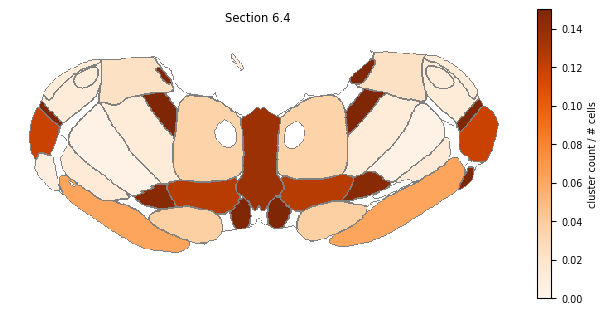

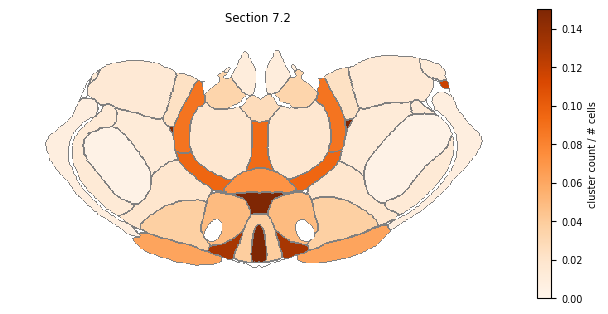

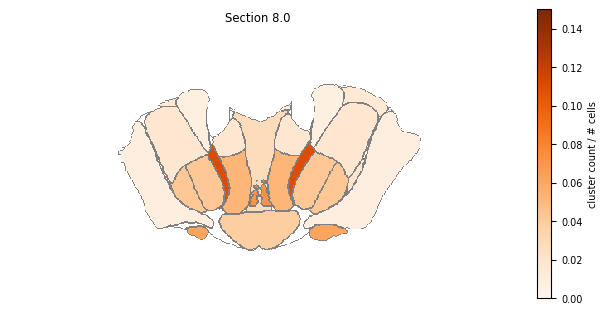

In [20]:
# plot the cell type counts in the CCF structures
figs = cplot.plot_metrics_ccf(ccf_images, 
                              th_ccf_metrics['count_norm2cells_cluster'], 
                              sections_3,
                              ccf_level=ccf_metrics_level,
                              vmin=0, vmax=0.15, cmap='Oranges',
                              cb_label='cluster count / # cells')

## Local diversity index

For a view of diversity that is not dependent on predefined region boundaries, we can calculate local diversity indices for each cell, using the same metrics for diversity of the cell-type distribution, but restricted to nearest neighbors of the cell. We demonstrate this for 15-cell neighborhoods, using the Inverse Simpson's index (equivalent to the cell type count if types are evenly distributed, but weighted so that smaller types contribute less).

The plotting method provided additionally smooths the cell-wise metrics onto a regular grid before plotting.

In [21]:
local_isi_df = divmet.calculate_local_diversity_metric(obs_erode, 
                                                       divmet.inverse_simpsons_index, 
                                                       metric_name='isi', 
                                                       n_neighbors=15)
obs_erode = obs_erode.join(local_isi_df)                                                    
local_isi_df

,local_isi_cluster,local_isi_supertype,local_isi_subclass
cell_label,,,
1018093344101260463-5,4.245283,2.528090,2.272727
1019171907102970225,5.232558,4.787234,3.169014
1018093344101260150-4,5.769231,4.591837,3.688525
1018093344102600178-2,5.769231,5.769231,2.710843
1018093344102510506-4,2.368421,2.368421,2.227723
...,...,...,...
1019171907102620076-1,1.000000,1.000000,1.000000
1020131842101890882,1.744186,1.300578,1.000000
1018093344102470409-5,1.642336,1.642336,1.000000


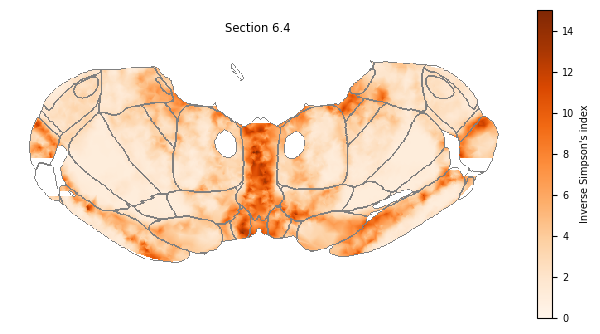

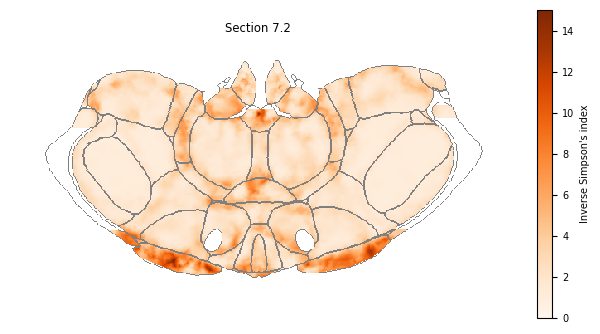

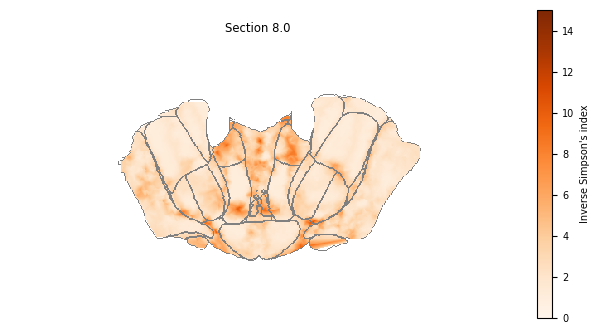

In [26]:
sections_3 = [6.4, 7.2, 8.0]
metric_name = 'local_isi_cluster'
for section in sections_3:
    fig = cplot.plot_local_metric_ccf_section(obs_erode, ccf_images,
                                              section, metric_name, label="Inverse Simpson's index")

## Proportions as stacked bar graphs

We also visualize the diversity and specific cell-type distributions of each region as a stacked barplot with distinct segments/colors for each type. Types containing less than 1% of the cells in the region are excluded and greyed out (alternatively, can be thresholded by count).

### Subclass proportions by region

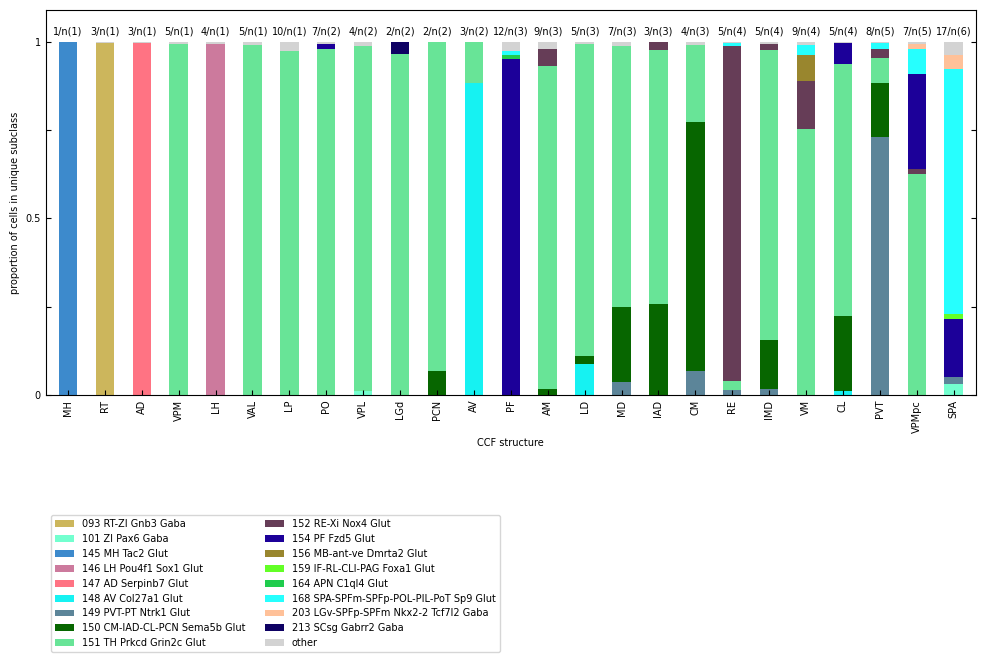

In [27]:
fig = dplot.barplot_stacked_proportions(obs_erode, 'subclass', th_ccf_metrics, abc.TH_DIVERSITY_STRUCTURES,
                                        legend=True, min_cell_frac=0.01)   # other options: min_cell_count=5, min_cell_frac=0.05 

### Supertype proportions by region

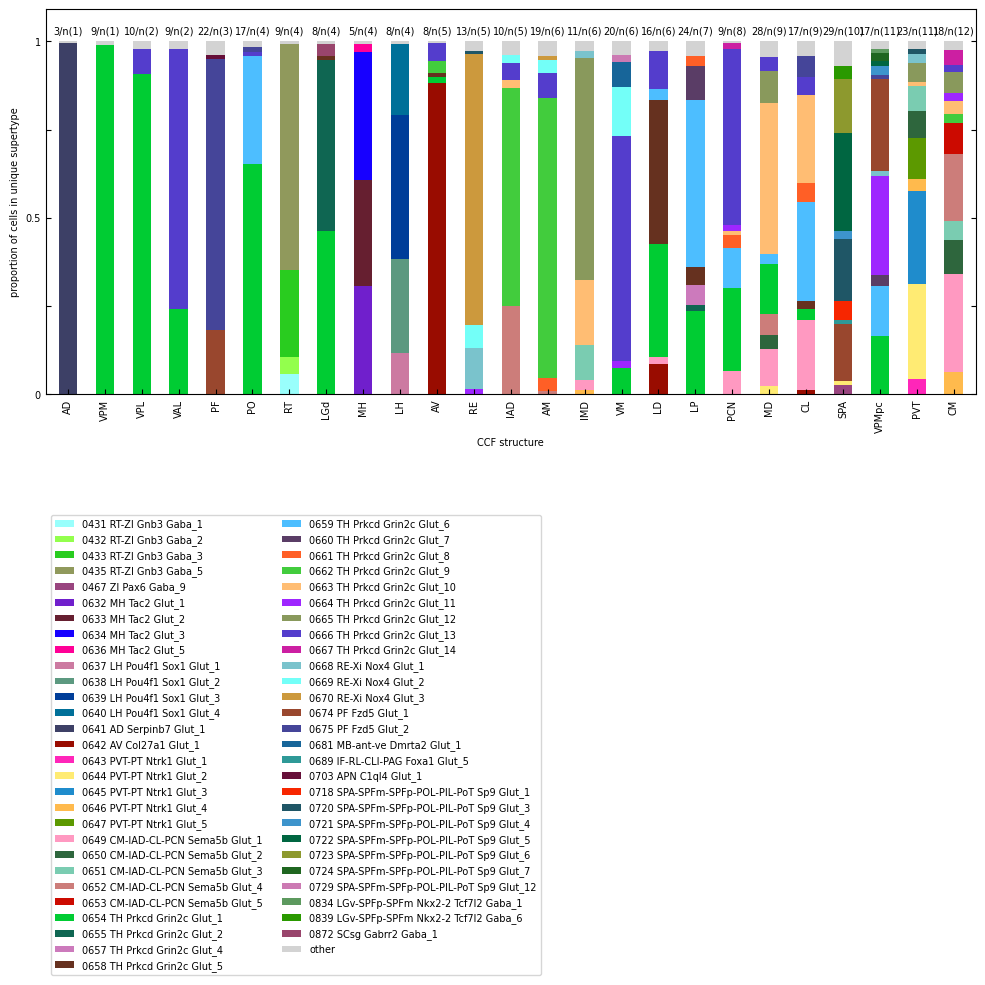

In [28]:
# filter clusters that represent <= 1% of cells in that region
fig = dplot.barplot_stacked_proportions(obs_erode, 'supertype', th_ccf_metrics,  abc.TH_DIVERSITY_STRUCTURES,
                                        legend=True, min_cell_frac=0.01)  # other options: min_cell_count=5, min_cell_frac=0.05 

### Cluster proportions by region

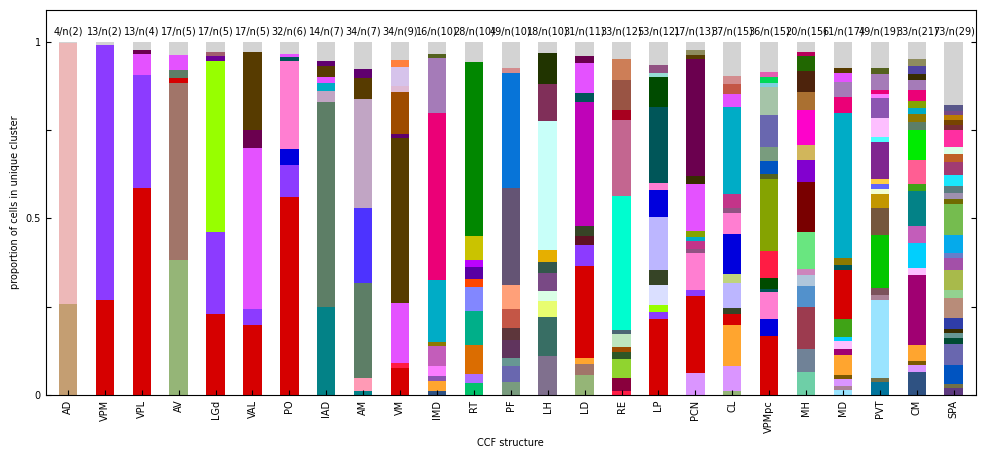

In [29]:
# without legend
# filter clusters that represent <= 1% of cells in that region
fig = dplot.barplot_stacked_proportions(obs_erode, 'cluster', th_ccf_metrics,  abc.TH_DIVERSITY_STRUCTURES,
                                        palette=abc.get_thalamus_cluster_palette(),
                                        legend=False, min_cell_frac=0.01)  # other options: min_cell_count=5, min_cell_frac=0.05